In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests

%matplotlib inline

In [2]:
csvpath = Path("../Data/CMI.csv")
stock_title = "Cummins Stock Price Prediction Model"

In [3]:
stock_df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
stock_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-25,$240.85,1055529,$240.67,$242.72,$239.96
2021-06-24,$239.11,997412,$239,$240.9017,$237.52
2021-06-23,$238,855927,$237.6,$239.19,$235.241
2021-06-22,$237.01,899676,$237.29,$238.469,$235.48
2021-06-21,$235.89,991528,$235.56,$239.24,$235.46


In [5]:
stock_df.sort_index(ascending=True, inplace=True)

In [6]:
stock_df = stock_df.rename(columns={"Close/Last": "Close"})

In [7]:
stock_df = stock_df[['Close']]
stock_df

,Close
Date,
2011-06-27,$97.39
2011-06-28,$100.7
2011-06-29,$101.04
2011-06-30,$103.49
2011-07-01,$107.42
...,...
2021-06-21,$235.89
2021-06-22,$237.01
2021-06-23,$238


In [8]:
stock_df['Close'] = stock_df['Close'].str.replace('$', '').astype(float)

In [9]:
stock_df

,Close
Date,
2011-06-27,97.39
2011-06-28,100.70
2011-06-29,101.04
2011-06-30,103.49
2011-07-01,107.42
...,...
2021-06-21,235.89
2021-06-22,237.01
2021-06-23,238.00


In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(stock_df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[ 97.39 100.7  101.04 103.49 107.42 105.65 106.78 108.82 106.77 103.65
  103.32 105.71 104.49 104.68 103.5  106.58 106.75 107.57 106.78 106.66
  110.82 106.49 105.74 104.88 103.79  99.15 101.54  93.16  92.26  83.67
   91.11  86.25  91.87  94.47  96.18  93.68  91.93  83.34  79.91  79.95
   84.15  86.58  85.13  87.47  90.46  90.98  92.92  90.76  86.82  85.54
   90.5   90.01  88.16  87.06  92.2   94.17  97.86  97.84  97.03  94.25
   91.61  85.26  86.26  89.48  91.91  86.95  86.45  81.66  81.01  85.12
   88.32  90.02  90.17  94.08  95.75  95.71  95.48  97.6   92.37  93.76
   90.49  91.84  94.22  98.82  93.81  94.88 101.71 102.75  99.43  96.03
   98.77 103.24 103.39 101.   101.68  96.35  97.28  98.72  99.41  99.23]
 [100.7  101.04 103.49 107.42 105.65 106.78 108.82 106.77 103.65 103.32
  105.71 104.49 104.68 103.5  106.58 106.75 107.57 106.78 106.66 110.82
  106.49 105.74 104.88 103.79  99.15 101.54  93.16  92.26  83.67  91.11
   86.25  91.87  94.47  96.18  93.68  91.93  8

In [12]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
y_train

array([[ 98.03],
       [ 94.78],
       [ 94.02],
       ...,
       [151.28],
       [150.79],
       [152.06]])

In [14]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [15]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [19]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 11s 383ms/step - loss: 0.0258
Epoch 2/20
15/15 [==============================] - 6s 393ms/step - loss: 0.0113
Epoch 3/20
15/15 [==============================] - 6s 375ms/step - loss: 0.0113
Epoch 4/20
15/15 [==============================] - 6s 374ms/step - loss: 0.0057
Epoch 5/20
15/15 [==============================] - 6s 380ms/step - loss: 0.0065
Epoch 6/20
15/15 [==============================] - 6s 413ms/step - loss: 0.0059
Epoch 7/20
15/15 [==============================] - 6s 415ms/step - loss: 0.0055
Epoch 8/20
15/15 [==============================] - 6s 395ms/step - loss: 0.0047
Epoch 9/20
15/15 [==============================] - 6s 396ms/step - loss: 0.0048
Epoch 10/20
15/15 [==============================] - 6s 394ms/step - loss: 0.0043
Epoch 11/20
15/15 [==============================] - 6s 418ms/step - loss: 0.0042
Epoch 12/20
15/15 [==============================] - 6s 393ms/step - loss: 0.0043
Epoch 13/20
15/15 [=====

In [20]:
model.evaluate(X_test, y_test, verbose=0)

0.021172283217310905

In [21]:
predicted = model.predict(X_test)

In [22]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [23]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
stock_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = stock_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stock_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-23,153.10,156.556442
2017-08-24,152.38,155.887772
2017-08-25,151.80,155.320358
2017-08-28,152.10,154.838638
2017-08-29,152.71,154.446426


In [25]:
stock_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-21,233.00,226.669006
2021-06-22,235.89,225.363403
2021-06-23,237.01,223.981781
2021-06-24,238.00,222.672333
2021-06-25,239.11,221.539169


<AxesSubplot:title={'center':'Cummins Stock Price Prediction Model'}, xlabel='Date', ylabel='Price'>

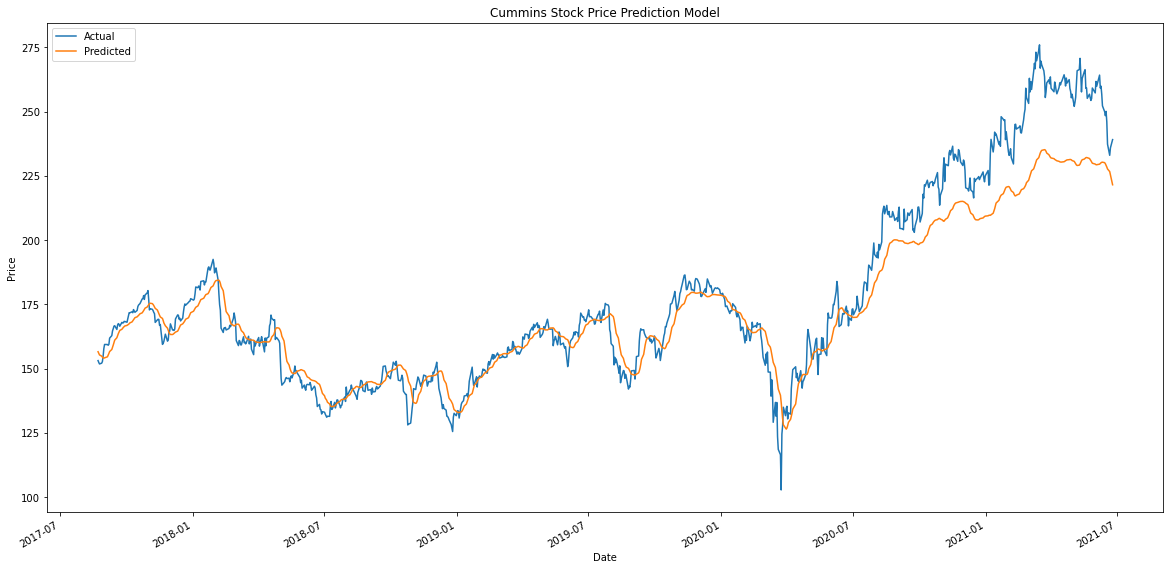

In [26]:
stock_actual_predicted.plot(figsize=(20,10), ylabel="Price", title=stock_title)